In [1]:
import os
import numpy as np
import json
from skimage.draw import polygon
from PIL import Image
import matplotlib.pyplot as plt
from monai.losses import DiceLoss

In [8]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [9]:
import json

with open('val.json', 'r') as f:
    data = json.load(f)

In [10]:
root = '/home/menelaos/Documents/U-Nets'
image_dir = os.path.join(root, r'/home/menelaos/Documents/U-Nets/images/livecell_train_val_images')
# mask_dir = os.path.join(root, 'images/test/mask_dir/')

In [22]:
dir = '/home/menelaos/Documents/U-Nets/dataset/test_masks'
len(os.listdir(dir))


1512

### Process the masks based on .json file

In [11]:
# Get name of each image
image_name_list = []
files = os.listdir(image_dir)
for file in files:
    name, extension = os.path.splitext(file)
    if extension == '.tif':
        image_name_list.append(name)


In [12]:
image_id_to_segmentation = {}

# Collecting segmentation for each image_id
for image in data['images']:
    name, extension = os.path.splitext(image["file_name"])
    if name in image_name_list:
        image_id = image['id']
        segmentation_list = []
        for ann in data['annotations']:
            if ann['image_id'] == image_id:
                # Create a list of segmentation for each image, each list have corresponding (x, y) coordinate
                segmentation_list += ann['segmentation']
        image_id_to_segmentation[image_id] = {}
        image_id_to_segmentation[image_id]['segmentation'] = segmentation_list
        image_id_to_segmentation[image_id]['name'] = name


In [13]:
shape = (521, 705)

# Create a mask for corresponding image id
for image_id in image_id_to_segmentation.keys():
    combined_mask = np.zeros(shape, dtype=np.float32)
    segmentation_list = image_id_to_segmentation[image_id]['segmentation']
    for segmentation in segmentation_list:
        mask = np.zeros(shape, dtype=np.float32)
        rr, cc = polygon(segmentation[1::2], segmentation[0::2])
        mask[rr, cc] = 1
        combined_mask += mask
    name = image_id_to_segmentation[image_id]['name']
    # Save mask as gray scale image
    plt.imsave(rf'dataset/val_masks/{name}.png', combined_mask, cmap='gray')
    img_pil = Image.open(rf'dataset/val_masks/{name}.png')
    img_pil = img_pil.convert('L')
    img_pil.save(os.path.join(root, rf'dataset/val_masks/{name}.png'))
            

In [28]:
img_pil = Image.open(r'D:\programming\unet-livecell-project\images_test\test\mask_dir\A172_Phase_C7_1_00d00h00m_1.png')
img_pil = img_pil.convert('L')
img_pil.save('a.png')

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\programming\\unet-livecell-project\\images_test\\test\\mask_dir\\A172_Phase_C7_1_00d00h00m_1.png'

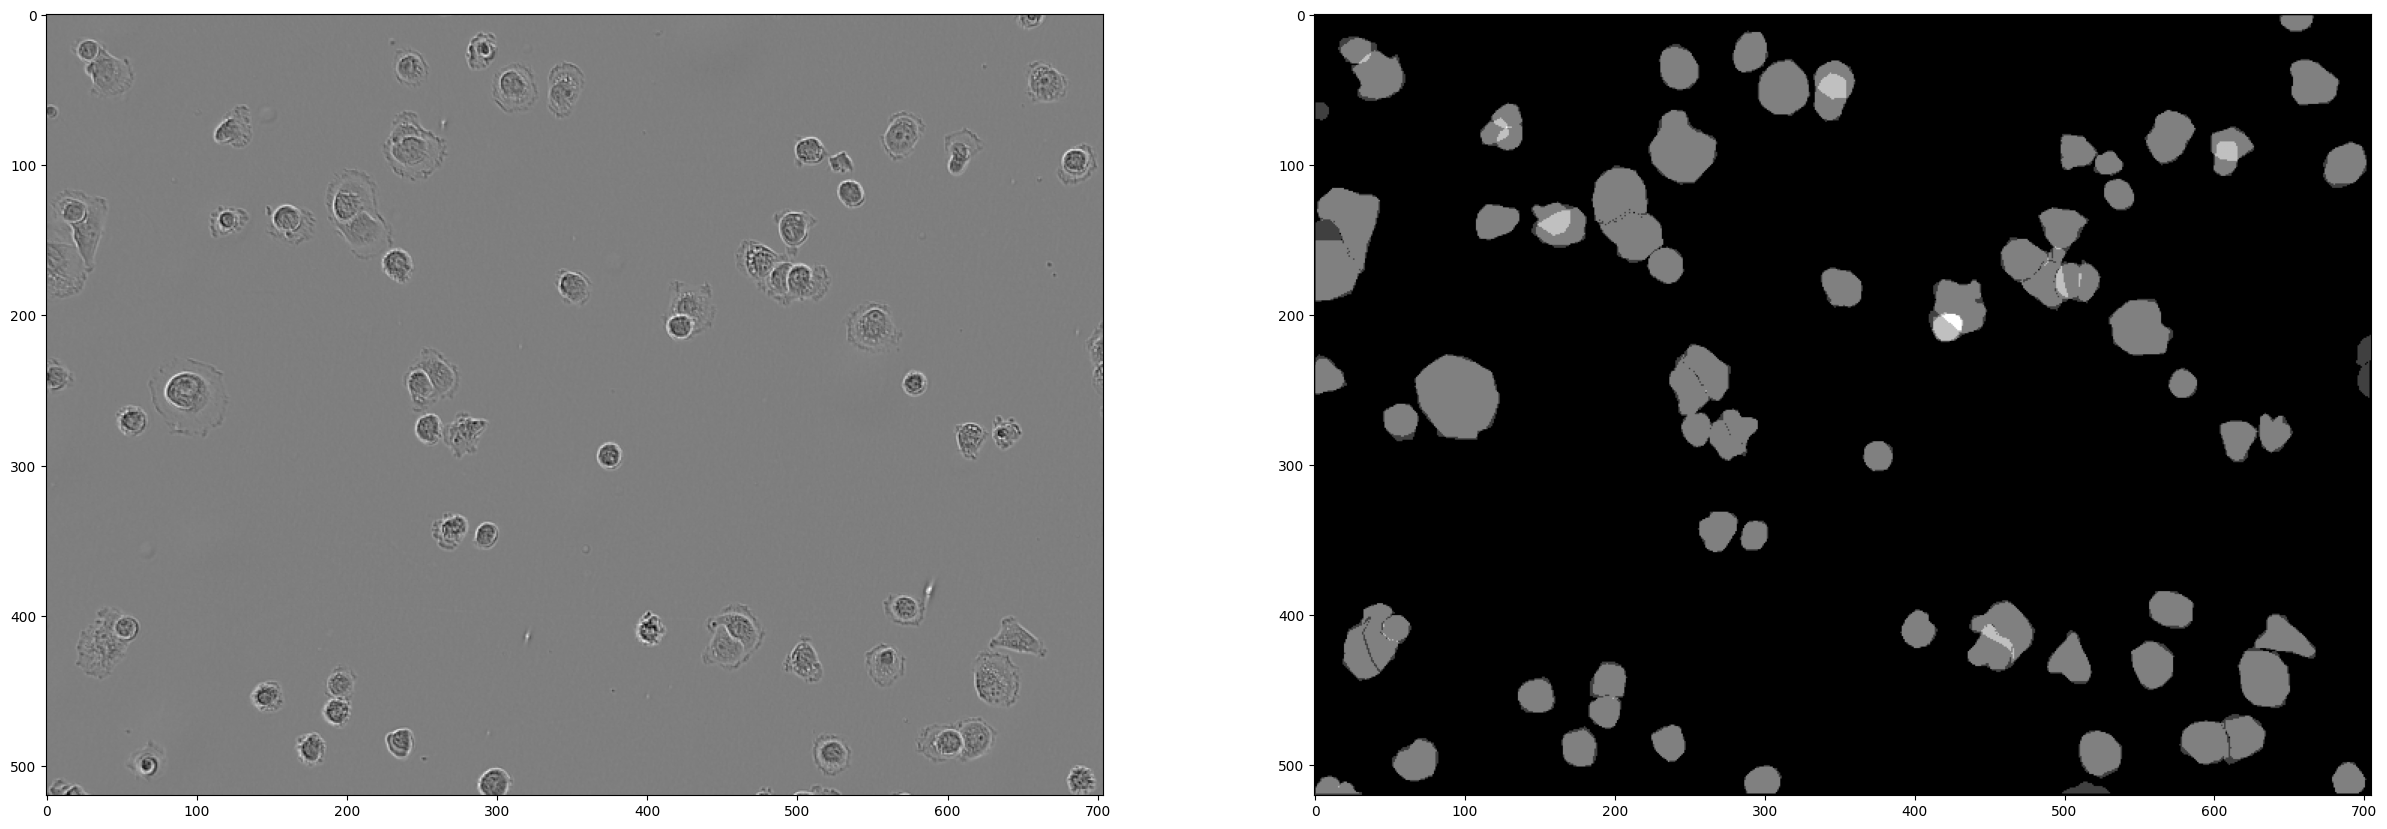

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(30,60))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(combined_mask, cmap='gray')


In [15]:
# Transform all the images to gray scale images
def transform_image(folder, save_folder, json_file):
    file_name_list = []
    for image in json_file['images']:
        file_name = image["file_name"]
        name, extension = os.path.splitext(file_name)
        file_name_list.append(name)
        print(len(file_name_list))
    for image in os.listdir(folder):
        name, extension = os.path.splitext(image)
        if name in file_name_list:
            img_path = os.path.join(folder, image)
            image = Image.open(img_path)
            image = image.convert('L')
            image.save(f'{save_folder}/{name}.png')
# image_dir = r'D:\programming\unet-livecell-project\images\livecell_test_images'
image_dir = r'/home/menelaos/Documents/U-Nets/images/livecell_train_val_images'
save_folder = r'/home/menelaos/Documents/U-Nets/dataset/val_images'
transform_image(image_dir, save_folder=save_folder, json_file=data)
            

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=1, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        # self.to("cuda")
        
    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


In [3]:
from torchvision.io import read_image
class CarvanaDataset():
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        image = read_image(img_path)
        mask = read_image(mask_path)
        
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)
        
        mask[mask == 255.0] = 1.0
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

In [23]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim

TRAIN_IMG_DIR = r"/home/menelaos/Documents/U-Nets/dataset/train_images"
TRAIN_MASK_DIR = r"/home/menelaos/Documents/U-Nets/dataset/train_masks"
VAL_IMG_DIR = r"/home/menelaos/Documents/U-Nets/dataset/val_images"
VAL_MASK_DIR = r"/home/menelaos/Documents/U-Nets/dataset/val_masks"
IMAGE_HEIGHT = 160  # 1280 originally
IMAGE_WIDTH = 240  # 1918 originally
EPOCHS = 2
LEARNING_RATE = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = UNET()
train_transform = torchvision.transforms.Compose(
    [   
        transforms.ToPILImage(),
        transforms.Resize((IMAGE_HEIGHT,IMAGE_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),        
    ],
)

val_transforms = torchvision.transforms.Compose(
    [   
        transforms.ToPILImage(),
        transforms.Resize((IMAGE_HEIGHT,IMAGE_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),
        
    ],
)
train_ds = CarvanaDataset(image_dir=TRAIN_IMG_DIR, mask_dir=TRAIN_MASK_DIR, transform= train_transform)
val_ds = CarvanaDataset(image_dir=TRAIN_IMG_DIR, mask_dir=TRAIN_MASK_DIR, transform= train_transform)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=True)

# loss_fn = nn.BCEWithLogitsLoss()
loss_fn = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

In [5]:
loss_list = []
for epoch in range(EPOCHS):
    train_epoch_loss = 0.0
    train_loss = 0.0
    for idx, (image, mask) in enumerate(train_loader):
        image = image.to(device=DEVICE)
        mask = mask.to(device=DEVICE)
        
        optimizer.zero_grad()
        prediction = model(image)
        loss = loss_fn(prediction, mask)
        
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
        if (idx+1) % 10 == 0:
            print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}"
                    .format(epoch+1, EPOCHS, idx+1, len(train_loader), loss.item()))
        loss_list.append(train_epoch_loss/len(train_loader))

/tmp/ipykernel_22482/17795175.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
/tmp/ipykernel_22482/17795175.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)
/home/menelaos/anaconda3/lib/python3.9/site-packages/monai/losses/dice.py:147: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


Epoch [1/50], Step [10/399], Loss: 1.1914
Epoch [1/50], Step [20/399], Loss: 0.9551
Epoch [1/50], Step [30/399], Loss: 1.0096
Epoch [1/50], Step [40/399], Loss: 1.0710
Epoch [1/50], Step [50/399], Loss: 0.9439
Epoch [1/50], Step [60/399], Loss: 1.0374
Epoch [1/50], Step [70/399], Loss: 0.9257
Epoch [1/50], Step [80/399], Loss: 0.9998
Epoch [1/50], Step [90/399], Loss: 0.9662
Epoch [1/50], Step [100/399], Loss: 1.0803
Epoch [1/50], Step [110/399], Loss: 0.9743
Epoch [1/50], Step [120/399], Loss: 0.9086
Epoch [1/50], Step [130/399], Loss: 1.0289
Epoch [1/50], Step [140/399], Loss: 1.0196
Epoch [1/50], Step [150/399], Loss: 0.9554
Epoch [1/50], Step [160/399], Loss: 0.9871
Epoch [1/50], Step [170/399], Loss: 0.9644
Epoch [1/50], Step [180/399], Loss: 0.9636
Epoch [1/50], Step [190/399], Loss: 0.9598
Epoch [1/50], Step [200/399], Loss: 0.9350
Epoch [1/50], Step [210/399], Loss: 0.9989


RuntimeError: Unsupported image file. Only jpeg and png are currently supported.

In [ ]:
torch.save(model.state_dict(), 'model/model.pth')
torch.save(model, 'model/model.pt')

In [ ]:
def save_predictions_as_imgs(loader, model, folder=".", device="cuda"):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        preds = preds.cpu().numpy()
        plt.imshow(preds.squeeze(0).squeeze(0), cmap='binary')
        
        # plt.imsave('image.png', image)
save_predictions_as_imgs(val_loader, model)

In [ ]:
model = UNET()
state_dict = torch.load('model/model.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

C:\Users\PC\AppData\Local\Temp\ipykernel_7488\1754592972.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\PC\AppData\Local\Temp\ipykernel_7488\1754592972.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


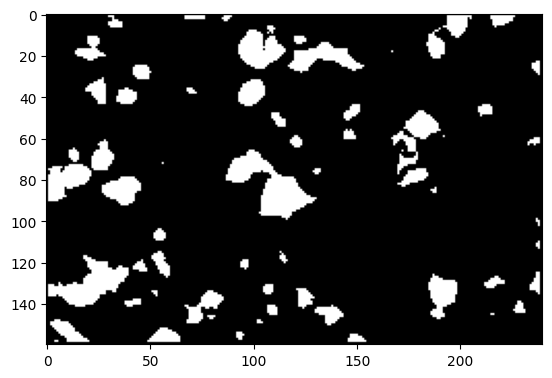

In [ ]:
model.eval()
input, mask = next(iter(val_loader))
image = input[1].unsqueeze(0)
image = image.to(DEVICE)
preds = torch.sigmoid(model(image))
preds = (preds > 0.5).float()
preds = preds.cpu().numpy()
plt.imshow(preds.squeeze(0).squeeze(0), cmap='gray')
